In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.io import imread, imshow
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage import gaussian_filter
import pandas as pd
import cv2
import os
from tqdm import tqdm
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance, distance_matrix
from cProfile import Profile
import scipy.ndimage as nd
from scipy.signal import find_peaks,peak_prominences
from scipy.optimize import curve_fit
from multiprocessing import Process
from scipy import fftpack
from skimage import measure
from scipy.interpolate import interp2d
from scipy.spatial.distance import euclidean
from skimage.exposure import rescale_intensity
from skimage.feature import peak_local_max
from scipy import spatial
import networkx as nx
from copy import deepcopy
import itertools
import sys
code_path = os.path.abspath('E:/code/HRTEM-grain-seg/utils/')

if code_path not in sys.path:
    sys.path.append(code_path)
    
from orientation_mapping import *
from FFT_image_process import *
from graph_cut import *

from matplotlib.markers import MarkerStyle
%matplotlib notebook
matplotlib.interactive(True)

############ global parameters
median_interatomic_dist = 0

# read videos

In [2]:
image = read_image('E:/code/HRTEM-grain-seg/data/Substack.avi', 5)

# FFT for interatomic distance

In [3]:
Peak_position = get_peak_position(image, 10000)
Peak_start, Peak_end =  int(Peak_position*0.7), int(Peak_position*1.3) # begin and end of radial mask

<IPython.core.display.Javascript object>


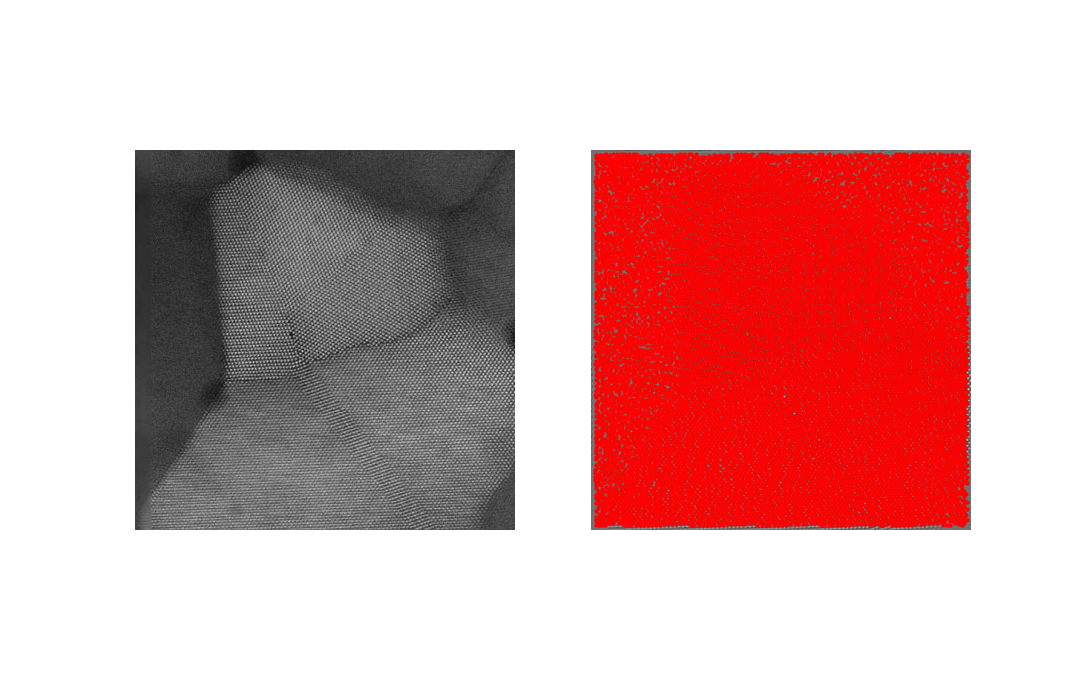

5.0


In [4]:
Peak_start, Peak_end =  int(Peak_position*0.8), int(Peak_position*1.3)
im_filtered = fft_filtered_image(image, Peak_start, Peak_end)
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

plt.subplot(1,2,2)
plt.imshow(im_filtered, cmap='gray')
plt.axis('off')
plt.show()
coordinates_all = peak_local_max(im_filtered, min_distance=1,exclude_border=5)
plt.scatter(coordinates_all[:, 1], coordinates_all[:, 0],s=1.5, color = 'r')
vor = Voronoi(coordinates_all)
median_interatomic_dist = find_median_interatomic_dist(vor)
print(median_interatomic_dist)

# rough grain segmentation by iFFT

<IPython.core.display.Javascript object>


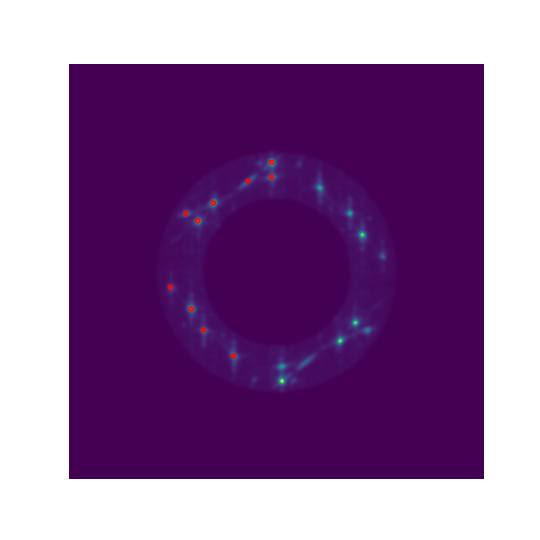

In [5]:
FFT, blobs_log = find_diff_spots(im_filtered, 3)
fig, axes = plt.subplots(figsize=(4,4))
plt.imshow(FFT)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), 1, color='r', linewidth=2, fill=True)
    axes.add_patch(c)
axes.set_axis_off()

[array([250, 121]), array([159, 193]), array([166, 328])]
[array([178, 171]), array([151, 302])]
[array([203, 360]), array([178, 171]), array([125, 275])]
[array([250, 139]), array([151, 302]), array([144, 184])]
[array([221, 144]), array([250, 121]), array([159, 193]), array([166, 328])]


E:\code\HRTEM-grain-seg\utils\FFT_image_process.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grains = np.array(grains)


<IPython.core.display.Javascript object>


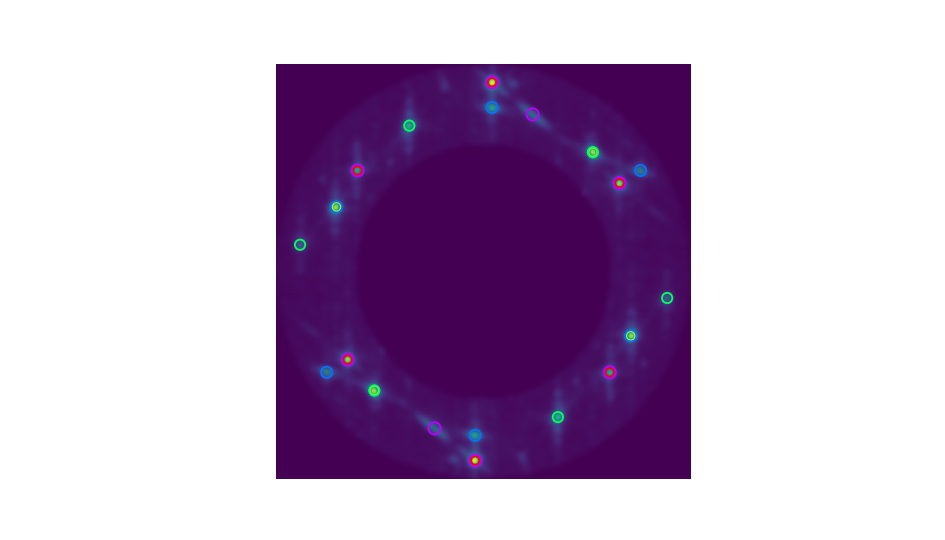

In [6]:
R_diffspot = 5   ############################################## crop size at fft diff spot
size_thres = 2000  ########################################### size threshold that can be taken as a grain
diff_spots, grain_masks = group_diff_spots(image, blobs_log, size_thres, 0.8,R_diffspot, 0.5)
cmap = matplotlib.cm.get_cmap('hsv')
fig, axes = plt.subplots(figsize=(7,4))
plt.imshow(FFT)
plt.xlim(FFT.shape[1]//2 - Peak_end, FFT.shape[1]//2 + Peak_end)
plt.ylim(FFT.shape[1]//2 - Peak_end, FFT.shape[1]//2 + Peak_end)
for j, k in enumerate(diff_spots):
    for i in k:
        c = plt.Circle((i[0], i[1]), 3+j/3, color=cmap(j/len(diff_spots)), linewidth=1, fill=False)
        axes.add_patch(c)
        c = plt.Circle(( FFT.shape[1]-i[0], FFT.shape[0]-i[1]), 3+j/3, color=cmap(j/len(diff_spots)), linewidth=1, fill=False)
        axes.add_patch(c)
axes.set_axis_off()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.36it/s]


<IPython.core.display.Javascript object>


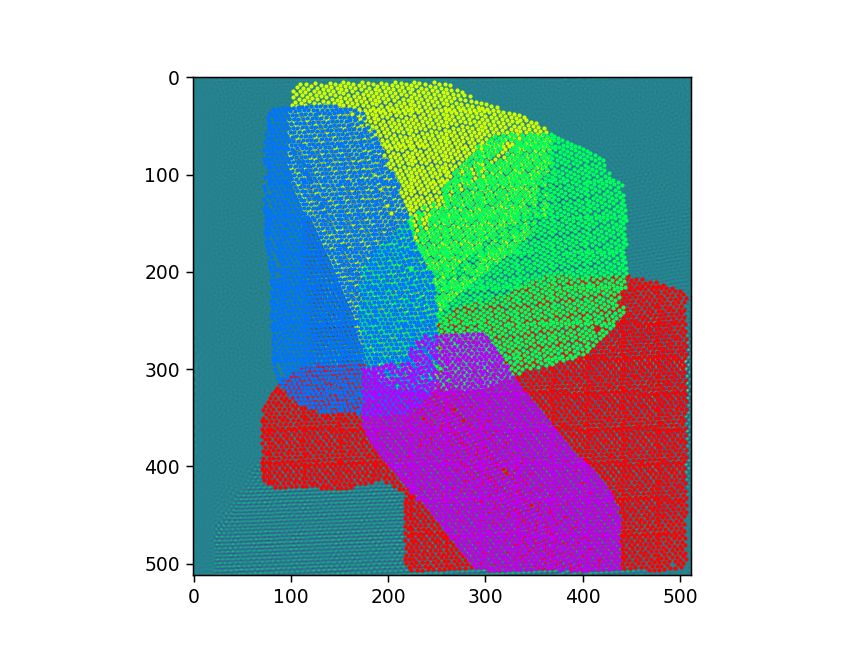

In [7]:
grain_atoms, coordinates_all = find_grain_atoms(diff_spots, grain_masks, im_filtered, R_diffspot, int(median_interatomic_dist*0.5),0.01)
plt.figure()
plt.imshow(im_filtered)
for j, atoms in enumerate(grain_atoms):
    plt.scatter(atoms[:, 1], atoms[:, 0],s=1.5, color = cmap(j/len(grain_atoms)))

# grain segmentation based on distance from the ifft atom loc

In [8]:
dist_list = get_dist_list(grain_atoms, coordinates_all)
c_list = label_atoms_by_dist(dist_list, 3)

0 4441
1 2096
2 1926
3 1639
4 1936


<IPython.core.display.Javascript object>


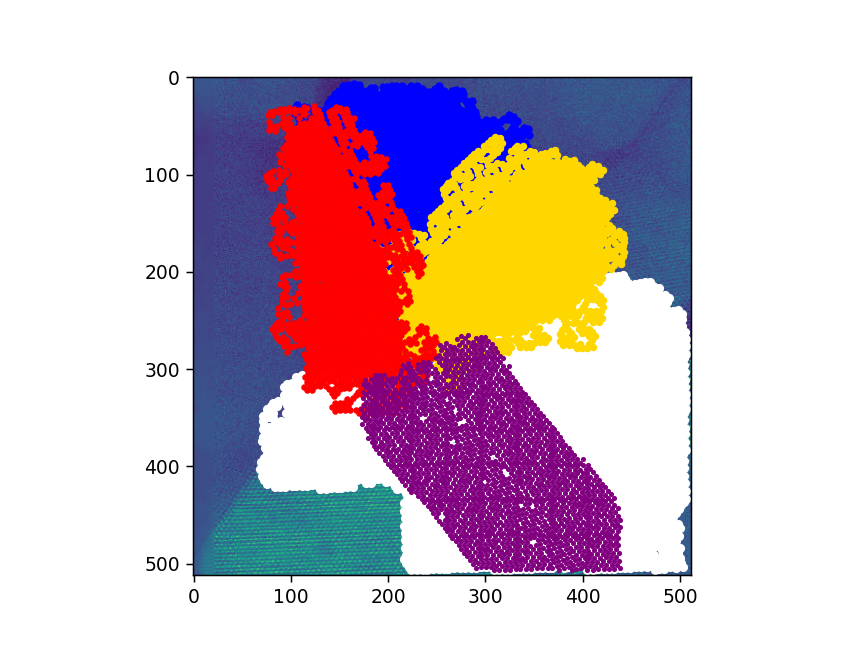

Number of atoms reduced


<IPython.core.display.Javascript object>


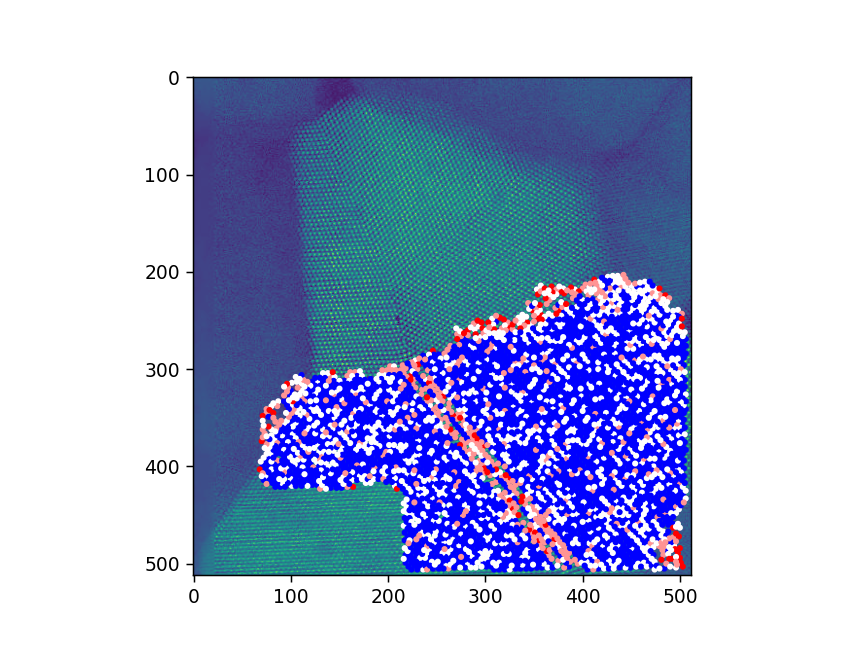

<IPython.core.display.Javascript object>


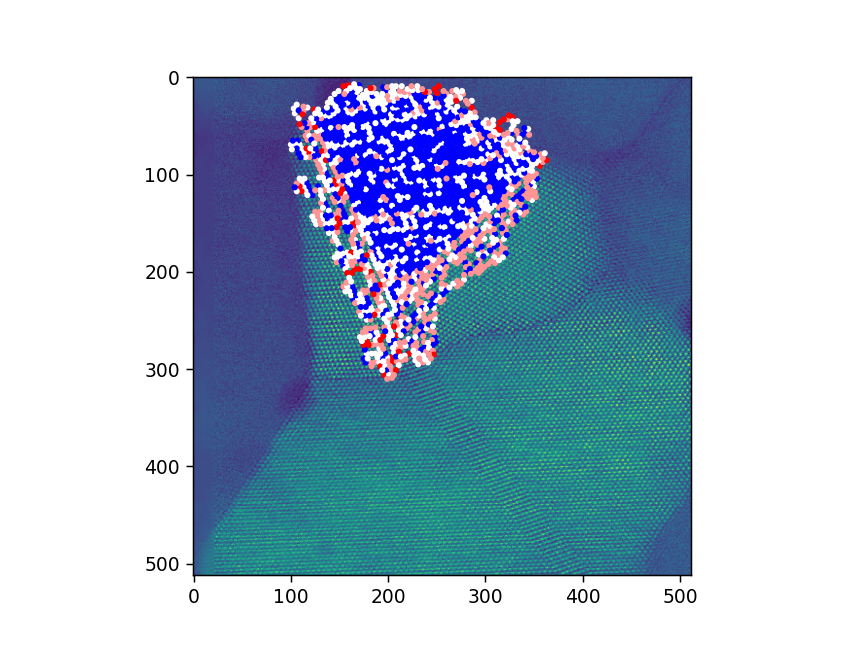

<IPython.core.display.Javascript object>


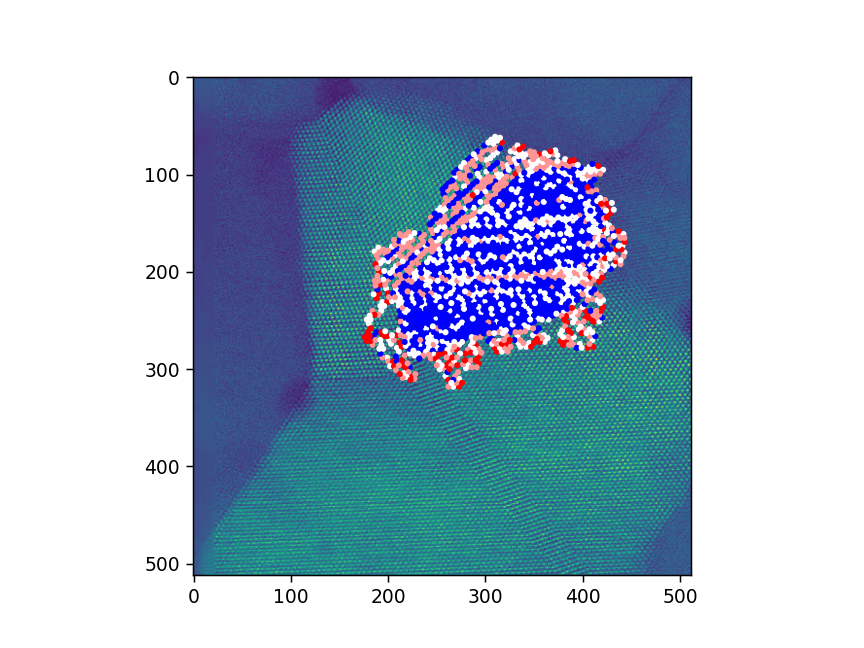

<IPython.core.display.Javascript object>


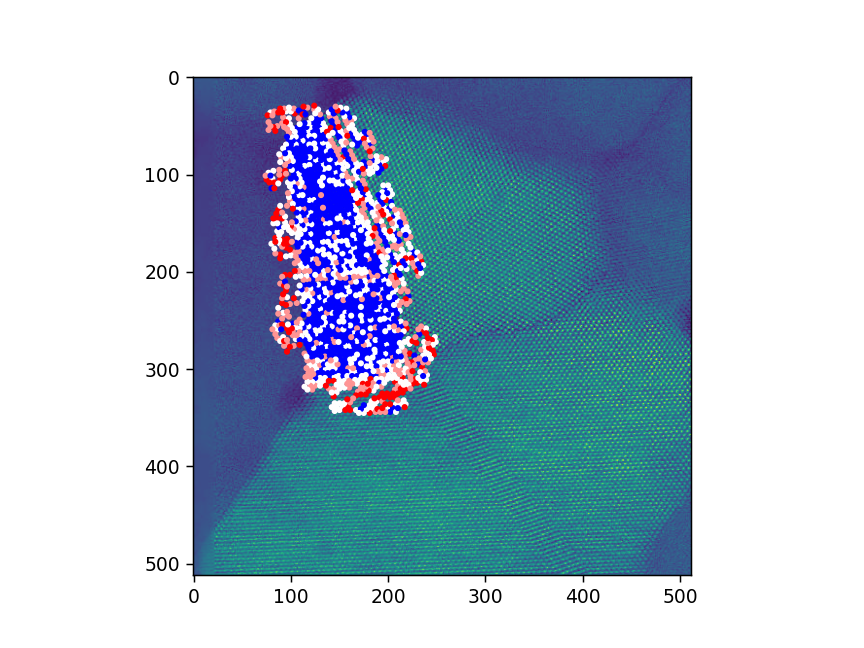

<IPython.core.display.Javascript object>


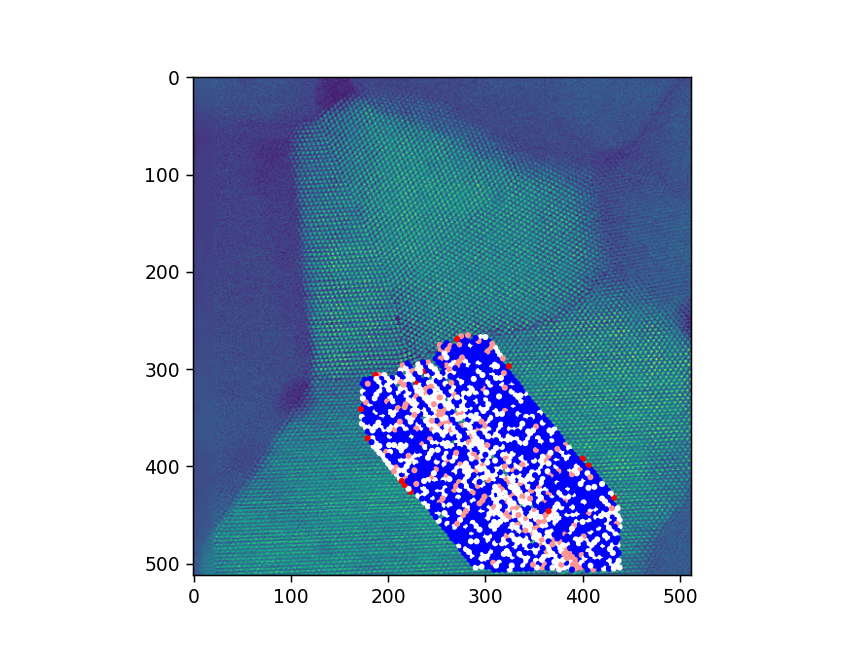

In [9]:
colors = ['w','b','gold','r','purple','cyan','yellow','orange','k']
components, new_dist_list = get_connected(coordinates_all, dist_list, median_interatomic_dist/4*1.7, 2, 100, median_interatomic_dist)
plt.figure()
plt.imshow(image)
for i,cmp in enumerate(components):
    plt.scatter(cmp[:, 1], cmp[:, 0],s=15-3*i, c= colors[i])
    
#################################################################### update coordinate_all, remove unlabeled atoms
if coordinates_all.shape[0] > (new_dist_list.min(axis=1) != np.inf).sum():
    print('Number of atoms reduced')
    coordinates_all_new = coordinates_all[new_dist_list.min(axis=1) != np.inf]
    new_dist_list = new_dist_list[new_dist_list.min(axis=1) != np.inf]
####################################################################
bool_list = dist_list < median_interatomic_dist/4*1.1
for i in range(bool_list.shape[1]):
    plt.figure()
    plt.imshow(image)
    plt.scatter(coordinates_all_new[:, 1], coordinates_all_new[:, 0],s=5, c= new_dist_list[:,i], cmap='bwr')

# Orientation mapping

<IPython.core.display.Javascript object>


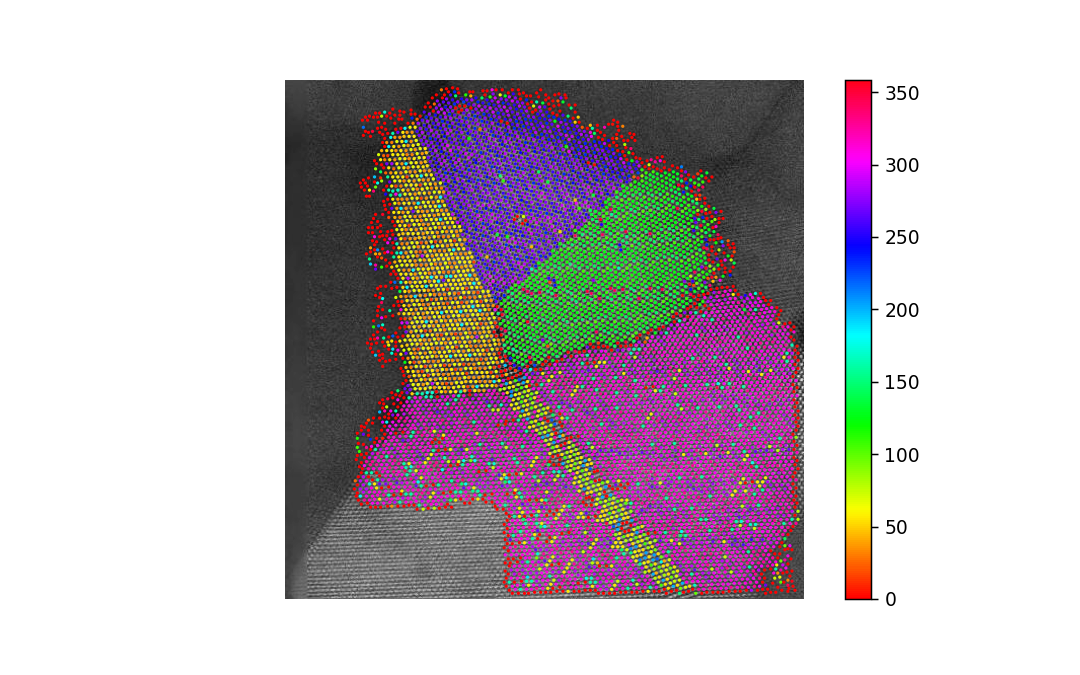

100%|████████████████████████████████████████████████████████████████████████████| 8183/8183 [00:01<00:00, 7699.07it/s]


In [10]:
ideal_vectors, angle_ideal = get_ideal_factor_for_fcc('110')
plt.figure(figsize=(8,5))
plt.imshow(image, cmap='gray')
plt.axis('off')
vor = Voronoi(coordinates_all_new)
angles = get_angles(vor,ideal_vectors, angle_ideal)
plt.scatter(coordinates_all_new[:, 1], coordinates_all_new[:, 0],s=0.5, c= 360/3.14*np.array(angles), cmap='hsv')
plt.colorbar()

# Orientation mapping with simply defined template

<IPython.core.display.Javascript object>


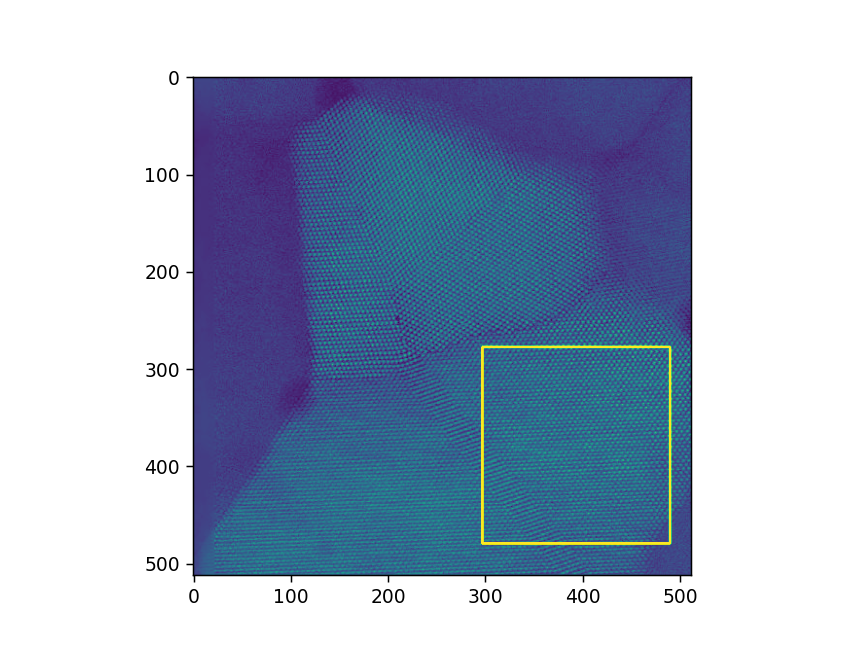

E:\code\HRTEM-grain-seg\utils\orientation_mapping.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  im1 = (20*np.log10( 0.1 + F2)).astype(int)


0 193 0 202


<IPython.core.display.Javascript object>


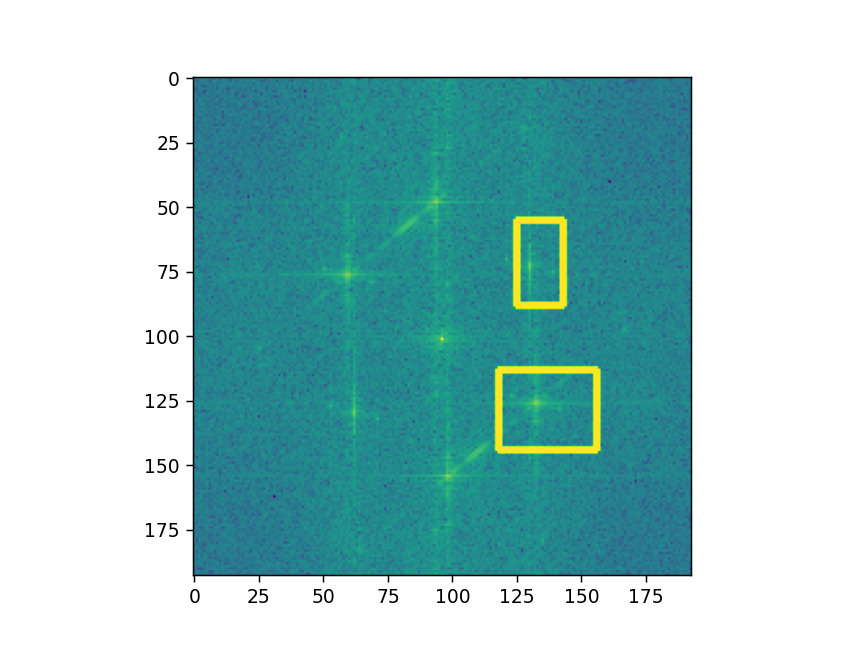

spot of interests =  [[73, 130], [126, 132]]


<IPython.core.display.Javascript object>


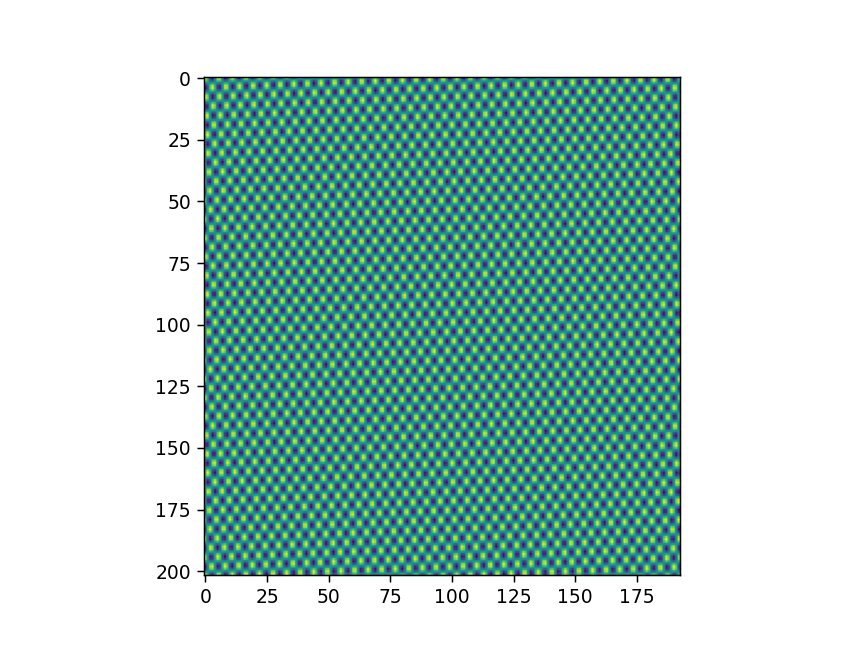

<IPython.core.display.Javascript object>


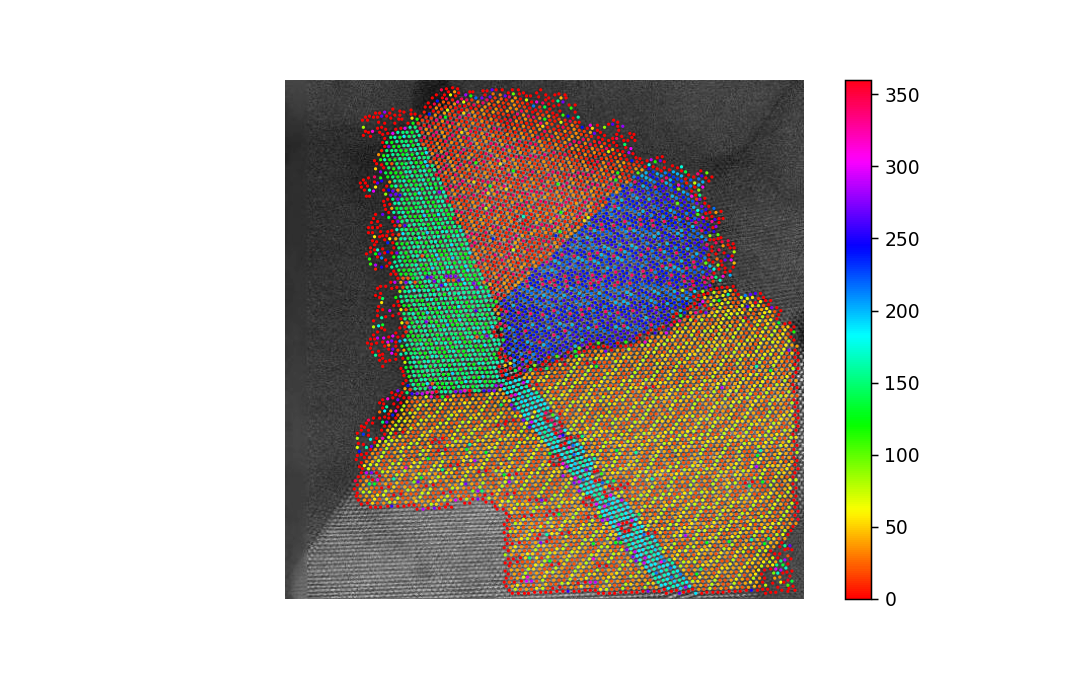

100%|████████████████████████████████████████████████████████████████████████████| 8183/8183 [00:01<00:00, 7769.81it/s]


In [11]:
img_template = template_map(image)
plt.figure()
plt.imshow(img_template)
ideal_vectors, angle_ideal = get_template_factors(img_template)
plt.figure(figsize=(8,5))
plt.imshow(image, cmap='gray')
plt.axis('off')
vor = Voronoi(coordinates_all_new)
angles = get_angles(vor,ideal_vectors, angle_ideal)
plt.scatter(coordinates_all_new[:, 1], coordinates_all_new[:, 0],s=0.5, c= 360/3.14*np.array(angles), cmap='hsv')
plt.colorbar()